# Project: Finding Patterns of Patient Keeping Appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

For this project, I have decided to use the a dataset containing information on over 100k medical appointments in Brazil. It was originally published on Kaggle under the question of whether or not we can predict if patients show up for their appointments. The dataset provides information on when patients were scheduled for appointments, whether they made their appointment, their location, their age, and other characteristics. I will be exploring the dataset to see if we can answer the question of whether we can predict a patients attendance based on the data we were given.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar as cal
from collections import OrderedDict

%matplotlib inline
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<a id='wrangling'></a>
## Data Wrangling

### Looking at the Initial Dataset

First lets give a quick lookover the dataset to see what we are dealing with.

In [2]:
data = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 44.8 MB


In [25]:
data.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,days_between,day,month,no_cats,weeks
0,29872499824296.00,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,elder,0,Friday,April,False,0 Week
1,558997776694438.00,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,middle age,0,Friday,April,True,0 Week
2,4262962299951.00,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,elder,0,Friday,April,True,0 Week
3,867951213174.00,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,childhood,0,Friday,April,True,0 Week
4,8841186448183.00,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,middle age,0,Friday,April,False,0 Week


In [4]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.00,110527.00,110527.00,110527.00,110527.00,110527.00,110527.00,110527.00,110527.00
mean,147496265710394.06,5675305.12,37.09,0.10,0.20,0.07,0.03,0.02,0.32
std,256094920291739.09,71295.75,23.11,0.30,0.40,0.26,0.17,0.16,0.47
min,39217.84,5030230.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4172614444192.00,5640285.50,18.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,31731838713978.00,5680573.00,37.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,94391720898175.00,5725523.50,55.00,0.00,0.00,0.00,0.00,0.00,1.00
max,999981631772427.00,5790484.00,115.00,1.00,1.00,1.00,1.00,4.00,1.00


### Cleaning up the dataset

Some initial observations:

- We can see in the age column that there appears to be a -1 age. That's definitely something we want to clean from our dataset.
- We can also see that the categories scholarship, hypertension, diabetes, alcoholism, and sms_received seem to be boolean in nature. Handicap sticks out with having 4 different options. Unfortunately, I could not find documentation detailing what each of those 4 options represent.
- The two columns with dates (ScheduledDay and AppointmentDay) will need to be converted. Furthermore, while ScheduledDay seems to indicate a specific time, all entries for AppointmentDay are set to 00:00:00 time.
- The column no-show has only two possible entries: no and yes. We can turn this into a boolean type for easier operations.

Now lets check to make sure there aren't any weird entries for our columns.

In [5]:
columns = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
for column in columns:
    print("{} => {}".format(column, sorted(data[column].unique())))

Gender => ['F', 'M']
Age => [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Scholarship => [0, 1]
Hipertension => [0, 1]
Diabetes => [0, 1]
Alcoholism => [0, 1]
Handcap => [0, 1, 2, 3, 4]
SMS_received => [0, 1]
No-show => ['No', 'Yes']


So far, everything seems to be as expected outside of the -1 age, which we have already noted. Lets fix that. In addition we will also change our column types and column names in the way we suggested above, change no-show to a boolean type, and convert ScheduledDay and AppointmentDay to a datatime column.

In [6]:
def noshow_to_bool(df):
    '''
    Changes Yes and No to True and False for the no-show column
    '''
    df = df.copy()
    df['no-show'] = df['no-show'].map({'Yes': True, 'No': False})
    return df
    
data = (data.rename(columns=str.lower)
            .query("age >= 0")
            #.pipe(noshow_to_bool)
            .assign(scheduledday = lambda x: pd.to_datetime(x['scheduledday']),
                    appointmentday = lambda x: pd.to_datetime(x['appointmentday'])))

## Adding Features (and More Cleaning!)

With the changes made to our dataframe, we can start adding some features. Specifically, I want to look at:

- The day of the appointment
- The month of the appointment
- How many days in between the schedule day and the appointment day
- Whether the patient came in for any of the categories listed
- What age group the patient would fall under

The range for the age groups will be:

- Toddler: 0-2
- Childhood: 3-12
- Teenager: 13-19
- Adulthood: 20-40
- Middle Age: 40-60
- Elderly: 60+

I came to these ranges after searching for guidelines on how age ranges are typically represented in health studies. In general, they change depending on the context of the research. For instance, the W.H.O groups ages in 0-9, 10-19, 20-59, and 60+ in regards to women's health studies, while other organizations use increments of 5 years. For this project I wanted to look at specific ranges that show major points in a person's lifespan, and how those timespans relate to hospital visits.



In [7]:
list(cal.day_name[1:])

['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [8]:
age_bins = [0, 3, 13, 20, 40, 60, np.inf]
week_bins = [0, 6, 13, 20, 27, np.inf]
age_labels = ['toddler', 'childhood', 'teenager', 'adulthood', 'middle age', 'elder']
week_labels = ['0 Week', '1 Week', '2 Weeks', '3 Weeks', '4+ Weeks']
categories = ['scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received']

data = data.assign(age_group = lambda x: pd.cut(x['age'], age_bins, labels=age_labels, include_lowest=True),
                   days_between = lambda x: (x['appointmentday'] - pd.to_datetime(x['scheduledday'].dt.date)).dt.days,
                   day = data['appointmentday'].apply(lambda x: cal.day_name[x.weekday()]).astype('category'),
                   month = data['appointmentday'].apply(lambda x: cal.month_name[x.month]).astype('category'),
                   no_cats = lambda x: (x[categories] == 0).all(1))

data = data.assign(weeks = lambda x: pd.cut(x['days_between'], week_bins, labels=week_labels, include_lowest=True))

data['age_group'].cat.reorder_categories(age_labels, ordered=True, inplace=True)
data['weeks'].cat.reorder_categories(week_labels, ordered=True, inplace=True)

Now that we have made these changes to our dataset, lets take a look at the values generated by our new columns and date values.

In [9]:
columns = ['month', 'day']
for column in columns:
    print("{} => {}".format(column, sorted(data[column].unique())))

month => ['April', 'June', 'May']
day => ['Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday']


Interestingly, when looking at the values generated by our month and day columns for appointments, we only get the months of April to June, and all days except for Sunday.

In [10]:
print("Earliest ScheduledDay: {}, Latest ScheduledDay: {}".format(min(data['scheduledday']), max(data['scheduledday'])))
print("Earliest AppointmentDay: {}, Latest AppointmentDay: {}".format(min(data['appointmentday']), max(data['appointmentday'])))

Earliest ScheduledDay: 2015-11-10 07:13:56, Latest ScheduledDay: 2016-06-08 20:07:23
Earliest AppointmentDay: 2016-04-29 00:00:00, Latest AppointmentDay: 2016-06-08 00:00:00


Looking at the earliest and latestest dates for our ScheduledDay column and AppointmentDay column reveals that our dataset actually only covers about 2 months worth of appointment data. Considering we are trying to find predictors for attendance, we have to keep this specific fact in mind. Time of the year can potentially affect attendance due to factors such as weather, and with only 2-3 months worth of data we only have a very small subset of time to work with.

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,days_between,day,month,no_cats,weeks
27033,7839272661752.00,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,adulthood,-1,Monday,May,False,NaN
55226,7896293967868.00,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,teenager,-1,Tuesday,May,False,NaN
64175,24252258389979.00,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,adulthood,-1,Wednesday,May,True,NaN
71533,998231581612122.00,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,elder,-6,Thursday,May,True,NaN
72362,3787481966821.00,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,childhood,-1,Tuesday,May,True,NaN


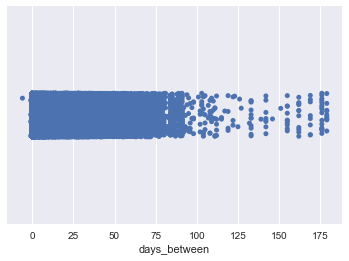

In [11]:
sns.stripplot(x='days_between', data=data, jitter=True)
data[data['days_between'] < 0]

A look at our day_between value reveals some bad data. Values less than 0 days should not exist.

In [12]:
data = data[data['days_between'] >= 0]

With that done, we can now start exploring our dataset!

<a id='eda'></a>
## Exploratory Data Analysis

### Are there any patterns we can find for patients who don't make appointments based on their condition?

First, lets write some functions that will help with our analysis.

In [13]:
def get_levels(data, column):
    levels = data[column].unique()
    rows = []
    for i in levels:
        row = OrderedDict()
        row['level'] = i
        row['no'] = (data[data[column] == i]['no-show'] == 'No').sum()
        row['yes'] = (data[data[column] == i]['no-show'] == 'Yes').sum()
        row['total'] = float(row['no']+row['yes'])
        row['no_pct'] = row['no']/row['total']
        row['yes_pct'] = row['yes']/row['total']
        rows.append(row)
        
    new_df = pd.DataFrame(rows, columns=row.keys())
    
    if column in data.select_dtypes(include=['category']):
        new_df['level'] = new_df['level'].astype('category')
        new_df['level'].cat.reorder_categories(data[column].cat.categories, inplace=True)
        
    return new_df

def graph(df, column, x='level', y='no_pct'):
    
    new_df = get_levels(df, column)
    sns.barplot(x=x, y=y, data=new_df)
    plt.title('Percentage of {} Patients Who Showed Up Based On Level'.format(column))
    plt.ylabel('Percentage')


Next, we want to get a general number for patient who keep their appointments.

In [14]:
data['no-show'].value_counts(normalize=True)

No    0.80
Yes   0.20
Name: no-show, dtype: float64

We can see, in general, about 80% of patients keep their medical appointments.

Now that we have our tools, and a baseline number, lets look at attendance numbers for the different conditions.

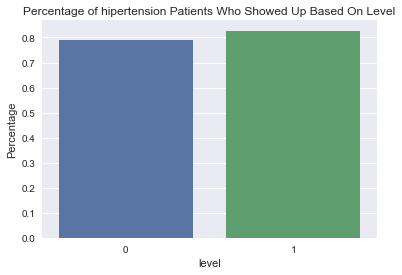

In [15]:
graph(data, 'hipertension')

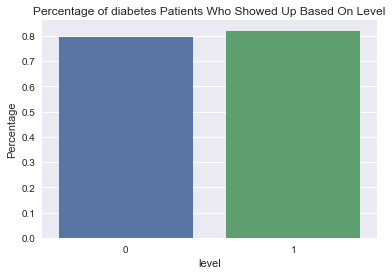

In [16]:
graph(data, 'diabetes')

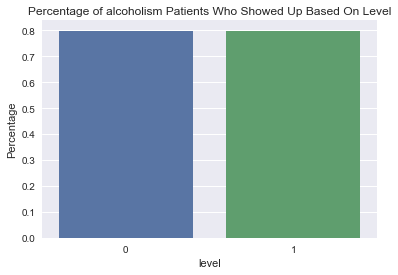

In [17]:
graph(data, 'alcoholism')

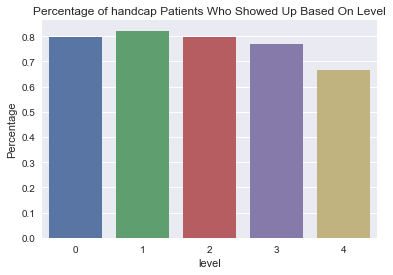

In [18]:
graph(data, 'handcap')

There were four specific conditions that were noted in the dataset.

- Hypertension
- Handicap
- Alcoholism
- and Diabetes

In the graphs above, we look at whether a patient was admitted for a given condition, and calculate the percentage who showed up for their appointment. As we can see from the graphs above, patients who come in for Hypertension, Alcoholism, or Diabetes have similar percentages to our baseline.

For handicap patients, there are five separate levels. Unfortunately, there was no information that accompanied the data set to explain what the different levels mean. It can be assumed based on the other the way the other categories are setup that level 0 indicates that handicap was not the reason for the patients appointment. From what we can see, levels 3 and 4 in the handicap category show much lower appearance percentages than the other levels, including those in the other 3 categories.

In [19]:
get_levels(data, 'handcap')

,level,no,yes,total,no_pct,yes_pct
0,0,86373,21909,108282.00,0.80,0.20
1,1,1676,364,2040.00,0.82,0.18
2,2,146,37,183.00,0.80,0.20
3,3,10,3,13.00,0.77,0.23
4,4,2,1,3.00,0.67,0.33


However, we can see from the actual data set that the number of people who came in for handicap levels 3 and 4 are too low to claim that it shows a pattern of attendance.

Finally, lets look at the remaining categories.

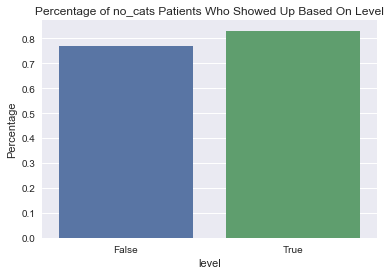

In [20]:
graph(data, 'no_cats')

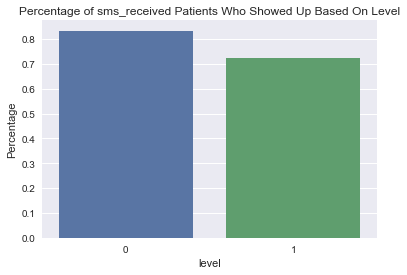

In [21]:
graph(data, 'sms_received')

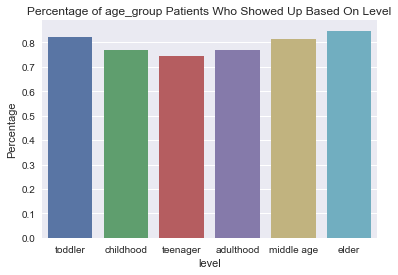

In [22]:
graph(data, 'age_group')

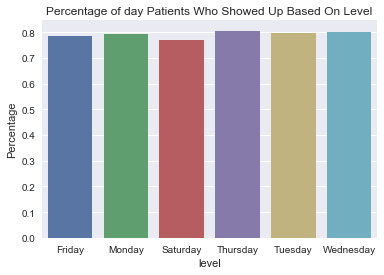

In [23]:
graph(data, 'day')

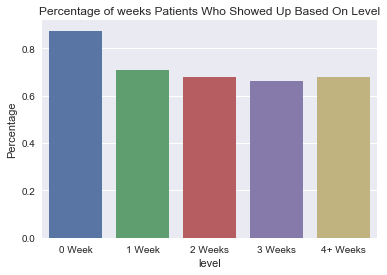

In [24]:
graph(data, 'weeks')

With this, we can see two specific data points that show a break with the baseline percentage. In terms of age groups, we can see a that older people are more likely to keep their medical appointments vs younger people. This would make sense, as older people generally have health issues that are time sensitive due to their age. Missing an appointment can have serious repercussions on the health of the patient.

We can also see that the further the time between the day the appiontment was scheduled and the day of the actual appointment. For appointments that are set more than 1 week out, there's a significant drop in the percentage of patients that show up. One reason for this is patients possibly forgetting their appointments, since they are so far out.

<a id='conclusions'></a>
## Conclusions

Overall, the data above is only a small sampling of a data. We have to remember that it only represents a small period of time of 3 months. As such, we can't assume that this data set is representive of the full population. Furthermore, some of the data points are not clear. Our handicap category have 5 different levels, but there was no information on what those levels represent. Also, for our sms received message, we don't know how the delivery occurred. We don't know if it was sent just once or multiple times, or if it was sent on the day the schedule occurred, or the day prior to the appointment. Knowing this can change our understanding of our statsitical analysis.

With that being said, based on the data we have we can see that most of our other data points have around the baseline percentage of 80% of appointees keeping their appointments. The only categories that seem to indicate some pattern as to a patient attending their appointment date is the time between the appointment and the day it was scheduled, and the patients age. This makes some intuitive sense, as older people have a greater importance on keeping track of their health, and dates that are far out from their original schedule can be forgotten or changed.